In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn
import xgboost as xgb
import sys
from calendar import monthrange
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


**Загружаем агрегированные данные:**

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-05.csv'
data = pd.read_csv(data_path)
data.rename(columns={'Unnamed: 0': 'time'}, inplace=True)

time_column = data.time
high_load_zones = data.mean().loc[data.mean() >= 5].index

In [0]:
pathes = ['/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-01.csv',
          '/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-02.csv',
          '/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-03.csv', 
          '/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-04.csv',
          '/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-05.csv',
          '/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/agregated/agr_yellow_tripdata_2016-06.csv']

monthes = []
for path in pathes:
  month = pd.read_csv(path)
  month.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
  monthes.append(month)

agr_data = pd.concat(monthes)
agr_data = agr_data.reset_index()
agr_data.drop('index', axis=1, inplace=True)
cols = high_load_zones.insert(0, 'time')
agr_data = agr_data[cols]

**Генерируем фичи, категориальные кодируем one-hot'ом:**

In [0]:
data = pd.DataFrame()

dataframes = []
reg_id = 1
for region in agr_data.columns[1:]:
    region_df = pd.DataFrame()
    region_df['time'] = agr_data.time
    region_df['trips'] = agr_data[region]
    region_df['region_id'] = reg_id
    dataframes.append(region_df)
    reg_id += 1

data = pd.concat(dataframes)
print data.shape

(445536, 3)


In [0]:
from IPython.display import display, clear_output
from ipywidgets import IntProgress
progress_bar = IntProgress(value=15, min=0, max=102, 
                           description='Processing',
                           bar_style='success')
progress_bar.value = 0
display(progress_bar)

objs_cnt = agr_data.shape[0] * 102
data = pd.DataFrame()

intervals = [i for i in range(1, 12)] + [i*24 for i in range(1, 7)] + [24*7*4]
sum_intervals = [12, 24, 24*7, 24*7*4] # add the month interval?
harmonics_cnt = 5

dataframes = []
reg_id = 1

for region in agr_data.columns[1:]:
    region_df = pd.DataFrame()
    region_df['time']  = agr_data.time
    region_df['trips'] = agr_data[region]
    region_df['region_id'] = region
    region_df['year']      = pd.DatetimeIndex(agr_data.time).year    
    region_df['month']     = pd.DatetimeIndex(agr_data.time).month
    region_df['week_day']  = pd.DatetimeIndex(agr_data.time).weekday
    for interval in intervals:
      region_df['y-{}'.format(interval)] = np.nan
      region_df['y-{}'.format(interval)][interval:] = region_df.trips[:-interval]
    for interval in sum_intervals:
      region_df['sum_{}'.format(interval)] = np.nan
      region_df['sum_{}'.format(interval)][interval:] = region_df.trips.rolling(interval).sum()[:-interval]
    for i in range(1, harmonics_cnt+1):
      region_df['sin_{}'.format(i)] = np.nan
      region_df['sin_{}'.format(i)] = np.sin(np.array(region_df.index) * 2 * np.pi * i / 168)
      region_df['cos_{}'.format(i)] = np.nan
      region_df['cos_{}'.format(i)] = np.cos(np.array(region_df.index) * 2 * np.pi * i / 168)
      region_df['pol_{}'.format(i)] = np.array(region_df.index) ** i
    for i in range(1, 7):
      region_df['y+{}'.format(i)] = np.nan
      region_df['y+{}'.format(i)][:-i] = region_df.trips[i:]
    
    dataframes.append(region_df)
    reg_id += 1
    progress_bar.value += 1

data = pd.concat(dataframes)

regions_encoded = pd.get_dummies(data.region_id)
regions_encoded.columns = ['reg_{}'.format(i) for i in range(1, 103)]
year_encoded = pd.get_dummies(data.year)
year_encoded.columns = ['year_{}'.format(i) for i in np.unique(data.year)] 
month_encoded = pd.get_dummies(data.month)
month_encoded.columns = ['month_{}'.format(i) for i in np.unique(data.month)]
week_day_encoded = pd.get_dummies(data.week_day)
week_day_encoded.columns = ['week_day_{}'.format(i) for i in np.unique(data.week_day)]

data = pd.concat([data, 
                  regions_encoded, 
                  year_encoded, 
                  month_encoded, 
                  week_day_encoded], axis=1)

print "Done!"


IntProgress(value=0, bar_style=u'success', description=u'Processing', max=102)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!


In [0]:
train = data.loc[data.month <= 4].dropna()
valid = data.loc[data.month == 5].dropna()
test  = data.loc[data.month == 6].dropna()

In [0]:
feat_cols = set(data.columns) - set(['time', 
                                     'y+1', 'y+2', 'y+3', 'y+4', 'y+5', 'y+6', 
                                     'region_id', 'week_day', 'year'])

**Выберем регрессор, начнем с Ridge. Подберем его гиперпараметры:**

In [0]:
progress_bar = IntProgress(value=15, min=0, max=36, 
                          description='Searching...',
                          bar_style='Success')
progress_bar.value = 0
display(progress_bar)

alphas = [1,0.1,0.01,0.001,0.0001]
scores = []

X_train = train[feat_cols]
y_train = train['y+1']
X_valid = valid[feat_cols]
y_valid = valid['y+1']

for n in alphas: 
  ridge = Ridge(alpha=n, solver='auto', normalize=True)
  error = 0
  for i in range(1, 7):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    progress_bar.value += 1   
  scores.append(error / (6*102*739.))

IntProgress(value=0, bar_style=u'success', description=u'Searching...', max=36)

In [0]:
scores

[61.34667106906546,
 47.13906860948131,
 43.31743257385052,
 42.9728237357779,
 43.30252874689462]

Text(0,0.5,'score')

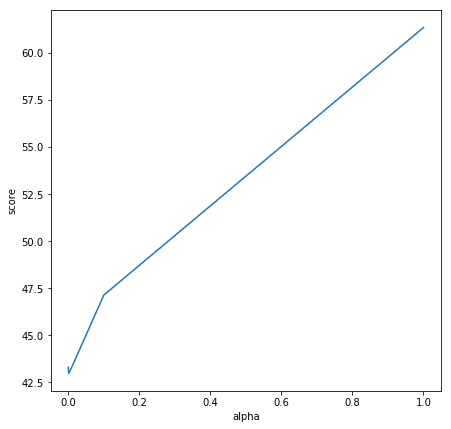

In [0]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(alphas, scores)
ax.set_xlabel('alpha')
ax.set_ylabel('score')

**Ошибка 42.9 - ну такое, попробуем Random forest:**

In [0]:
n_estimators = range(1, 61, 5)
max_depth = range(5, 41, 5)
max_features = range(5, len(feat_cols)+1, 10)

24 of 24

Text(0,0.5,'loss')

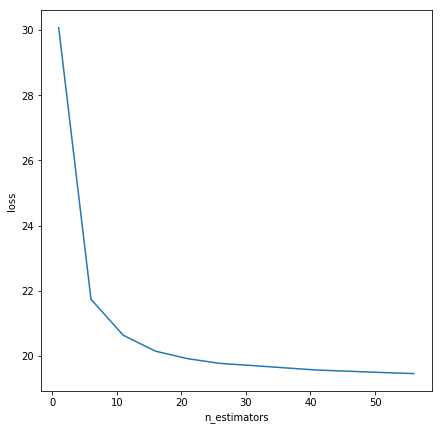

In [0]:
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in n_estimators: 
  forest = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(n_estimators)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('n_estimators')
ax.set_ylabel('loss')

In [0]:
best_n_estimators = 45

16 of 16

Text(0,0.5,'loss')

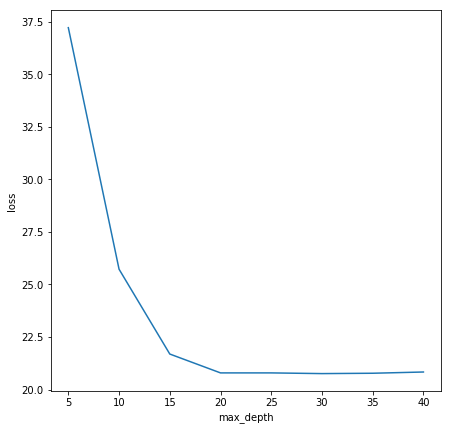

In [0]:
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in max_depth: 
  forest = RandomForestRegressor(max_depth=n,
                                 n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(max_depth)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('max_depth')
ax.set_ylabel('loss')

In [0]:
best_max_depth = 20

32 of 32

Text(0,0.5,'loss')

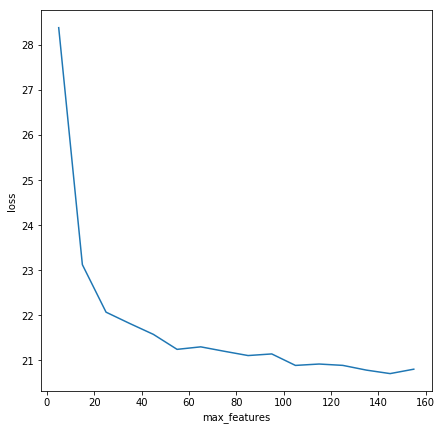

In [0]:
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in max_features: 
  forest = RandomForestRegressor(max_features=n,
                                 n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(max_features)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('max_features')
ax.set_ylabel('loss')

In [0]:
best_max_features = 145

**Итоговое предсказание на валидэйшн выборке:**

In [0]:
X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

forest = RandomForestRegressor(max_features=best_max_features,
                               max_depth=best_max_depth,
                               n_estimators=best_n_estimators,
                               n_jobs=-1, random_state=42)
error = 0
for i in range(1, 7):
  y_train = train['y+{}'.format(i)]
  y_valid = valid['y+{}'.format(i)]
  forest.fit(X_train, y_train)
  y_pred = forest.predict(X_valid)
  y_pred[y_pred < 0] = 0
  error += sum(abs(y_pred - y_valid))

  j += 1
  sys.stdout.write('\r')
  sys.stdout.write('{} of {}'.format(j, 6))
  sys.stdout.flush()
score = error / (6*102*739.)
print '\nScore =', score

Score = 21.9412501227


**Уже лучше. Попробуем еще XGBoost:**

In [0]:
depthes        = range(5, 31, 5)
estimators     = range(5, 101, 5)
learning_rates = [0.1, 1, 2, 3, 4, 5]

12 of 12

Text(0,0.5,'score')

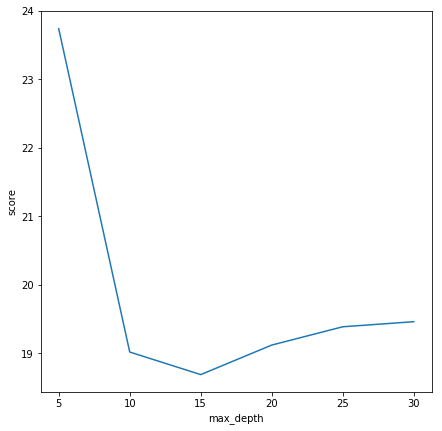

In [0]:
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in depthes: 
  boost = xgb.XGBRegressor(max_depth=n, n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(depthes)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('max_depth')
ax.set_ylabel('score')

10 of 10

Text(0,0.5,'score')

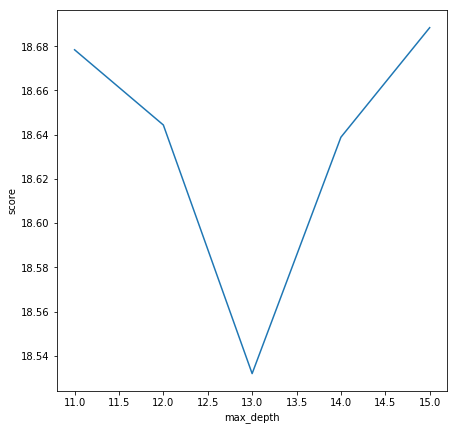

In [0]:
depthes = [11, 12, 13, 14, 15]
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in depthes: 
  boost = xgb.XGBRegressor(max_depth=n, n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(depthes)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('max_depth')
ax.set_ylabel('score')

In [0]:
best_max_depth = 13

40 of 40

Text(0,0.5,'score')

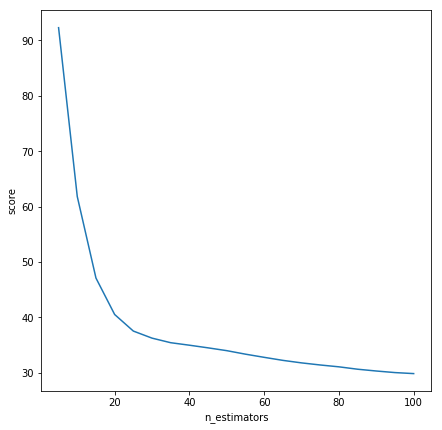

In [0]:
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in estimators: 
  boost = xgb.XGBRegressor(n_estimators=n, n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(estimators)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('n_estimators')
ax.set_ylabel('score')

14 of 14

Text(0,0.5,'score')

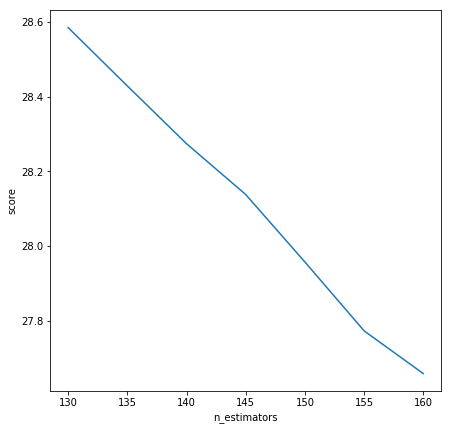

In [0]:
estimators = range(130, 161, 5)

scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in estimators: 
  boost = xgb.XGBRegressor(n_estimators=n, n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(estimators)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('n_estimators')
ax.set_ylabel('score')

In [0]:
best_n_estimators = 160

9 of 12

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


12 of 12

Text(0,0.5,'score')

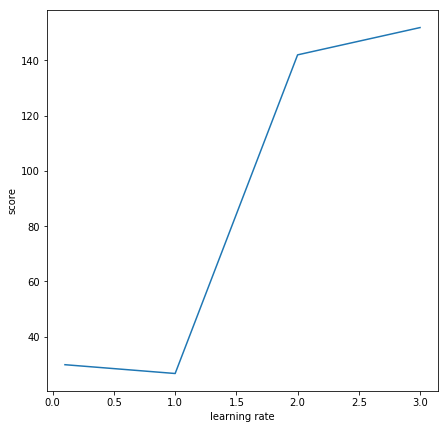

In [0]:
scores = defaultdict()

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

for n in learning_rates: 
  boost = xgb.XGBRegressor(learning_rate=n, n_jobs=-1, random_state=42)
  error = 0
  for i in range(1, 3):
    y_train = train['y+{}'.format(i)]
    y_valid = valid['y+{}'.format(i)]
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_valid)
    y_pred[y_pred < 0] = 0
    error += sum(abs(y_pred - y_valid))
    
    j += 1
    sys.stdout.write('\r')
    sys.stdout.write('{} of {}'.format(j, len(learning_rates)*2))
    sys.stdout.flush()
  scores[n] = error / (2*102*739.)
  
x, y = zip(*sorted(scores.items()))
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(x, y)
ax.set_xlabel('learning rate')
ax.set_ylabel('score')

In [0]:
best_learning_rate = 1

**Итоговое предсказание на валидэйшн выборке:**

In [0]:
score = 0

X_train = train[feat_cols]
X_valid = valid[feat_cols]

j = 0

boost = xgb.XGBRegressor(n_estimators=100, 
                         max_depth=best_max_depth,
                         learning_rate=0.01, 
                         n_jobs=-1, random_state=42)

error = 0
for i in range(1, 7):
  y_train = train['y+{}'.format(i)]
  y_valid = valid['y+{}'.format(i)]
  boost.fit(X_train, y_train)
  y_pred = boost.predict(X_valid)
  y_pred[y_pred < 0] = 0
  error += sum(abs(y_pred - y_valid))

  j += 1
  sys.stdout.write('\r')
  sys.stdout.write('{} of {}'.format(j, 6))
  sys.stdout.flush()
score = error / (6*102*739.)
  
print '\nScore =', score

Score = 36.0997918777


**Оставляем Random Forest и формируем сабмишн на Кеггл:**

In [0]:
test = pd.concat([valid[valid['time'] == '2016-05-31 23:00:00'], test])
valid.drop(valid[valid['time'] == '2016-05-31 23:00:00'].index, inplace=True)

In [0]:
y_pred  = defaultdict()
results = defaultdict()

error = 0

X = pd.concat([train[feat_cols], valid[feat_cols]])

for i in range(1, 7):
  y = pd.concat([train['y+{}'.format(i)], valid['y+{}'.format(i)]]).T
  
  forest = RandomForestRegressor(n_estimators=best_n_estimators,
                                 max_features=best_max_features,
                                 max_depth=best_max_depth,
                                 random_state=42, n_jobs=-1).fit(X, y)

  y_pred[i] = forest.predict(test[feat_cols])
  y_pred[i][y_pred[i] < 0] = 0
  error += sum(abs(y_pred[i] - test['y+{}'.format(i)]))
  
  sys.stdout.write('\r')
  sys.stdout.write('Processing inference: {} of {}'.format(i, 6))
  sys.stdout.flush()

error /= 6*102*739
print '\nDone!'
print 'Error =', error


test = test.reset_index()
test.time = pd.to_datetime(test.time)


results = []

for i in range(1, 7):
  result = pd.DataFrame()
  result['id'] = ['_'.join([str(test.iloc[row].region_id.split('_')[1]), 
                            str(test.iloc[row].time.strftime("%Y-%m-%d")),
                            str(test.iloc[row].time.hour),
                            str(i)]) for row in range(test.shape[0])]
  result['y'] = y_pred[i]
  results.append(result)

  sys.stdout.write('\r')
  sys.stdout.write('Writing results: {} of {}'.format(i, 6))
  sys.stdout.flush()

results = pd.concat(results)

results.to_csv('/content/drive/My Drive/Colab Notebooks/taxi_demand_prediction/data/results/results_features_with_may.csv', index=False)
print '\nDone!'

Processing inference: 6 of 6
Done!
Error = 21.109461879
Writing results: 6 of 6
Done!


https://www.kaggle.com/submissions/12762214/12762214.raw

In [0]:
def calc(a, b, cmd):
  if (cmd == 'summ'):
    return a + b
  elif (cmd == 'diff'):
    return a - b
  elif (cmd == 'umn'):
    return a * b
  else:
    print 'Error'
  
    

calc(58, 10090876, 'umn')